Number of numeric features used for heatmap: 31


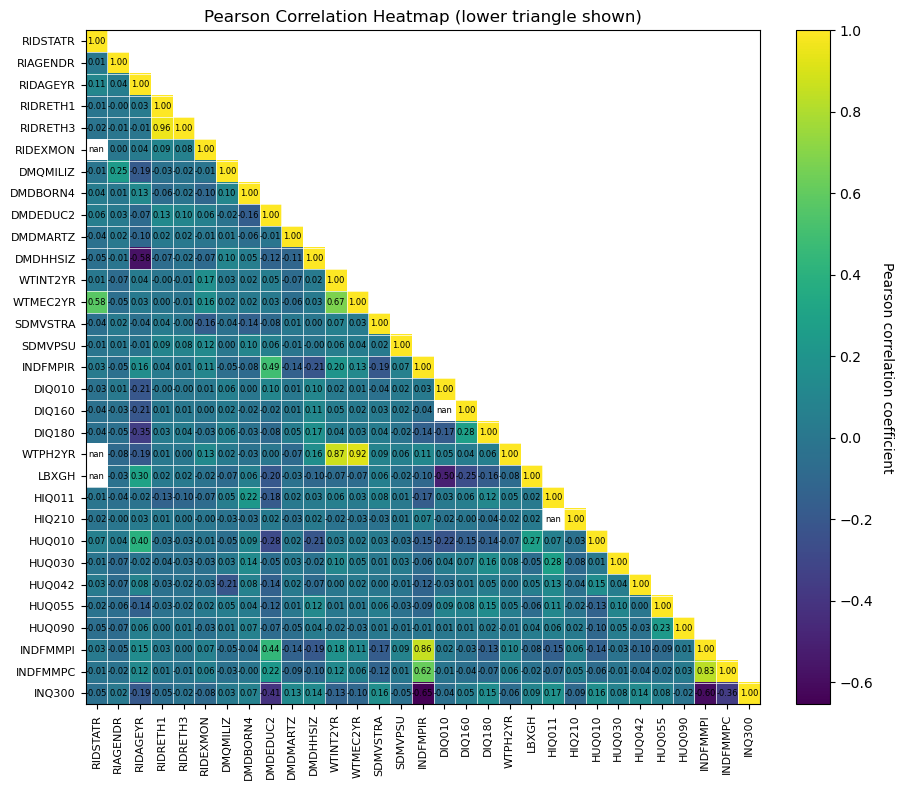

Saved heatmap to: figures/pearson_heatmap_all_features.png


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- SETTINGS ----------
CSV_PATH = 'Cleaning_data_cleaned.csv'   # file you specified
OUT_DIR = 'figures'
OUT_FILE = os.path.join(OUT_DIR, 'pearson_heatmap_all_features.png')
ANNOTATE_THRESHOLD = 50   # if #vars <= this, annotate cell values
os.makedirs(OUT_DIR, exist_ok=True)

# ---------- Load data ----------
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV file not found at: {CSV_PATH}")

df = pd.read_csv(CSV_PATH)

# ---------- Prepare numeric feature matrix ----------
# keep only numeric columns (drop non-numeric)
numeric_df = df.select_dtypes(include=[np.number]).copy()

# drop columns that are entirely missing
numeric_df = numeric_df.dropna(axis=1, how='all')

if numeric_df.shape[1] == 0:
    raise RuntimeError("No numeric columns found in the CSV after dropping fully-missing columns.")

# Optionally drop rows where everything is missing (rare)
numeric_df = numeric_df.dropna(axis=0, how='all')

# ---------- Compute Pearson correlation matrix ----------
corr = numeric_df.corr(method='pearson')

# sort variables by absolute correlation with the first column for nicer ordering (optional)
# Here we keep the natural ordering. If you prefer to reorder, uncomment following block:
#ref = corr.iloc[:,0].abs().sort_values(ascending=False).index
#corr = corr.loc[ref, ref]

vars_count = corr.shape[0]
print(f"Number of numeric features used for heatmap: {vars_count}")

# ---------- Create mask for upper triangle (so plot only lower triangle) ----------
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask, k=1)] = True  # mask upper triangle (k=1 keeps diagonal)

# create masked array so masked cells are not shown (will be white)
corr_masked = np.ma.masked_where(mask, corr.values)

# ---------- Plot heatmap ----------
fig_width = max(10, vars_count * 0.25)
fig_height = max(8, vars_count * 0.25)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# imshow the masked correlation matrix
cax = ax.imshow(corr_masked, interpolation='nearest', aspect='equal')

# ticks and labels
ax.set_xticks(np.arange(vars_count))
ax.set_yticks(np.arange(vars_count))
ax.set_xticklabels(corr.columns, rotation=90, fontsize=8)
ax.set_yticklabels(corr.index, fontsize=8)

# draw grid lines between cells for readability
ax.set_xticks(np.arange(-0.5, vars_count, 1), minor=True)
ax.set_yticks(np.arange(-0.5, vars_count, 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', bottom=False, left=False)

# colorbar
cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Pearson correlation coefficient', rotation=270, labelpad=15)

ax.set_title('Pearson Correlation Heatmap (lower triangle shown)')

# annotate values if dimension is small enough
if vars_count <= ANNOTATE_THRESHOLD:
    for i in range(vars_count):
        for j in range(vars_count):
            # only annotate lower triangle and diagonal (where mask is False)
            if not mask[i, j]:
                val = corr.values[i, j]
                ax.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=6)
else:
    # add note on the figure about no annotation
    ax.text(0.01, 0.99, 'Annotations omitted for readability (too many variables)',
            transform=ax.transAxes, va='top', ha='left', fontsize=9, bbox=dict(boxstyle='round', fc='w', alpha=0.7))

plt.tight_layout()
plt.savefig(OUT_FILE, dpi=200, bbox_inches='tight')
plt.show()

print(f"Saved heatmap to: {OUT_FILE}")